# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2018 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
year = "2019"
years = [2019]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 322624


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
17283,20190123061409PS,7516028,5/14/2021 12:00:00 AM,P190230098,3,1/23/2019 12:00:00 AM,1/23/2019 12:00:00 AM,05:16:29,1154,SUSPICIOUS VEHICLE,CAN,Canceled,[400]-[400] HOLGER WY,San Jose,CA,37.418433,-121.943118,Tasman and Zanker
66761,20190322185907PD,7592554,5/14/2021 12:00:00 AM,P190810760,2,3/22/2019 12:00:00 AM,3/22/2019 12:00:00 AM,18:22:31,415,DISTURBANCE,N,No report required; dispatch r,[1100]-[1200] BRANHAM LN,San Jose,CA,37.262537,-121.878153,Muir
303552,20191208223150PS,7952165,5/14/2021 12:00:00 AM,P193420847,3,12/8/2019 12:00:00 AM,12/8/2019 12:00:00 AM,20:42:05,20002,MISDEMEANOR HIT AND RUN,R,Report taken,STORY RD & LEEWARD DR,San Jose,CA,37.337010,-121.848110,Pink Elephant and PAL
38029,20190217093923PS,7548438,5/14/2021 12:00:00 AM,P190480239,3,2/17/2019 12:00:00 AM,2/17/2019 12:00:00 AM,08:31:29,10851,STOLEN VEHICLE,R,Report taken,[1900]-[1900] VOLLMER WY,San Jose,CA,37.347459,-121.845637,Mayfair
198839,20190815213737PD,7792577,5/14/2021 12:00:00 AM,P192270978,3,8/15/2019 12:00:00 AM,8/15/2019 12:00:00 AM,19:36:03,1125,TRAFFIC HAZARD,H,Courtesy Service/Citizen or ag,[400]-[500] N 17TH ST,San Jose,CA,37.351687,-121.879937,Northside-Backesto


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322624 entries, 0 to 322623
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              322624 non-null  object 
 1   EID               322624 non-null  int64  
 2   START_DATE        322624 non-null  object 
 3   CALL_NUMBER       322624 non-null  object 
 4   PRIORITY          322624 non-null  int64  
 5   REPORT_DATE       322624 non-null  object 
 6   OFFENSE_DATE      322624 non-null  object 
 7   OFFENSE_TIME      322624 non-null  object 
 8   CALLTYPE_CODE     322624 non-null  object 
 9   CALL_TYPE         322595 non-null  object 
 10  FINAL_DISPO_CODE  322624 non-null  object 
 11  FINAL_DISPO       322624 non-null  object 
 12  ADDRESS           312772 non-null  object 
 13  CITY              322624 non-null  object 
 14  STATE             322624 non-null  object 
 15  LATITUDE          289198 non-null  float64
 16  LONGITUDE         28

In [9]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.226240e+05,322624.000000,289198.000000,289198.000000
mean,7.735770e+06,3.351204,37.320996,-121.871364
std,1.416965e+05,1.396038,0.042977,0.047529
min,7.488585e+06,1.000000,37.150332,-122.035696
25%,7.613608e+06,2.000000,37.296855,-121.902506
50%,7.735370e+06,3.000000,37.324518,-121.869361
75%,7.858678e+06,4.000000,37.349085,-121.838813
max,7.981562e+06,6.000000,37.539229,-121.660052


In [10]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,322624,322624,322624,322624,322624,322624,322624,322595,322624,322624,312772,322624,322624,287684
unique,320487,1,316239,365,365,81098,209,202,22,18,31954,1,1,295
top,20191025203250PD,5/14/2021 12:00:00 AM,P192660947,8/23/2019 12:00:00 AM,8/23/2019 12:00:00 AM,22:37:21,415,DISTURBANCE,N,No report required; dispatch r,[200]-[300] W MISSION ST,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,322624,5,1100,1100,16,30260,30258,146755,146755,1744,322624,322624,8536


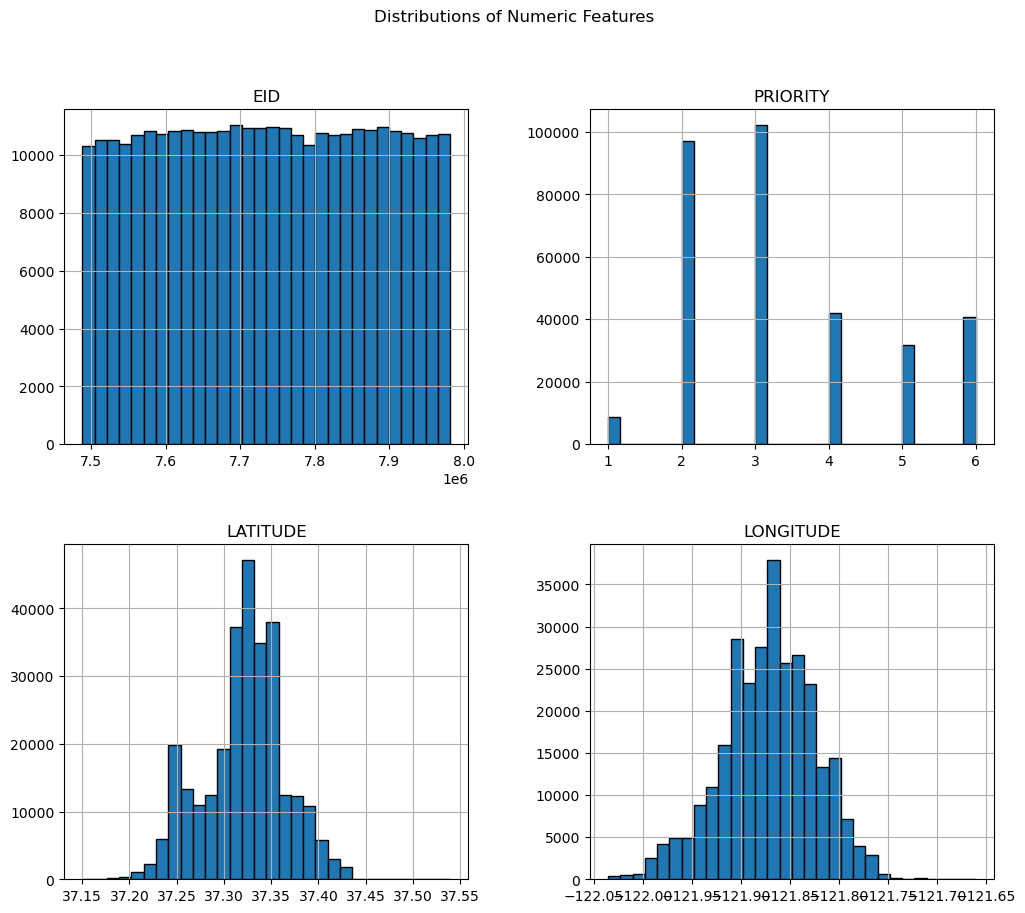

In [12]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [17]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE              29
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9852
CITY                    0
STATE                   0
LATITUDE            33426
LONGITUDE           33426
neighborhood        34940
dtype: int64

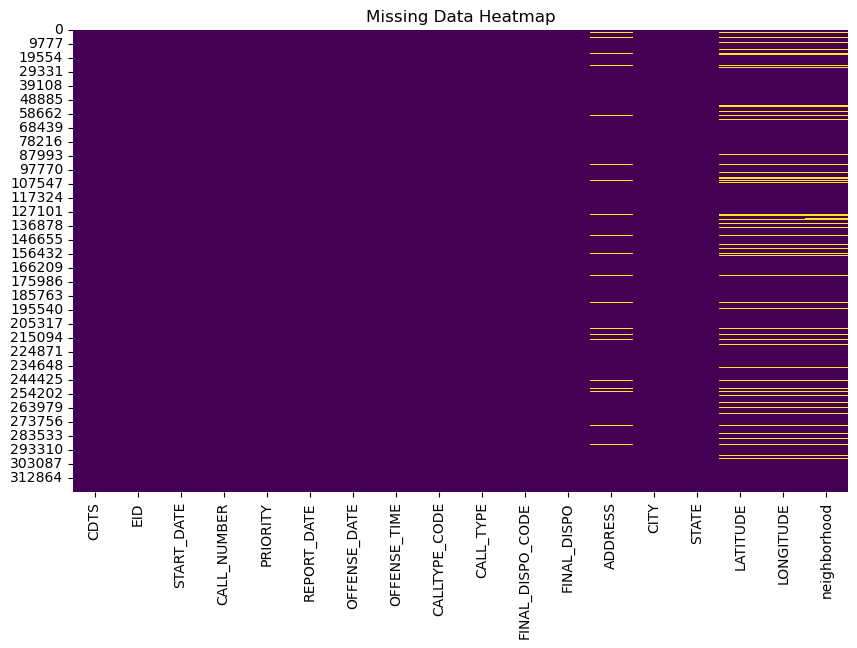

In [18]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [20]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 320487 unique values
START_DATE: 1 unique values
CALL_NUMBER: 316239 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81098 unique values
CALLTYPE_CODE: 209 unique values
CALL_TYPE: 202 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31954 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [23]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8536
Little Saigon and Spring Brook    5459
Trimble Business Area             4858
Fruitdale and Sherman Oaks        4777
Five Wounds-San Jose High         4721
                                  ... 
Los Alamitos Creek                  48
Linda Vista and Hillcrest           36
Meadowlands                         36
Alta Vista                          31
Santa Teresa Hills                  26
Name: count, Length: 295, dtype: int64

In [24]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          146755
CAN         46827
R           37038
G           20111
E           13928
D           10053
A            7225
U            5690
O            5291
DUPNCAN      5208
GD           4427
C            4214
H            3767
ADV          3279
B            3226
T            3079
NR           1305
F             949
M              86
Z              62
P              62
TOT            42
Name: count, dtype: int64

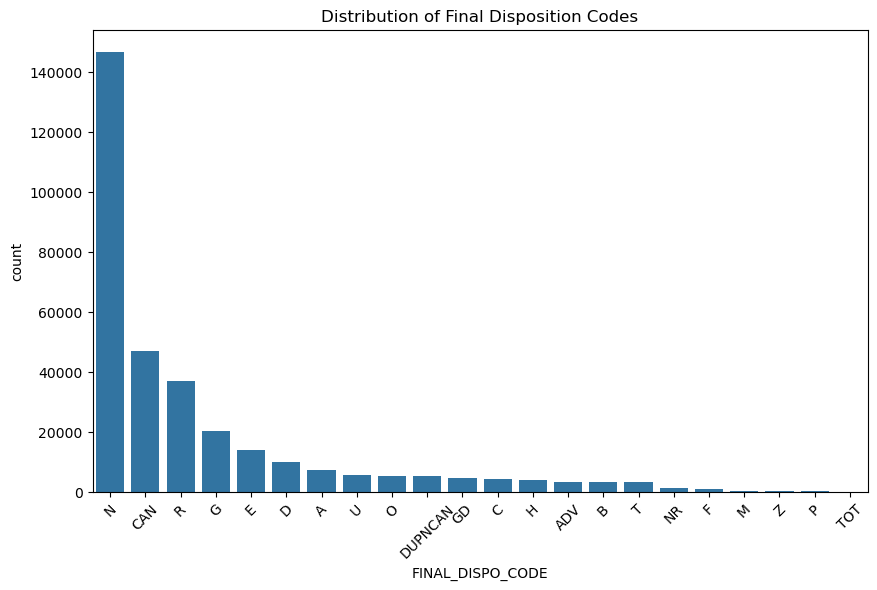

In [25]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [26]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    146755
Canceled                           46827
Report taken                       37038
Gone on Arrival/unable to loca     20111
Traffic Citation Issued, Non-H     13928
No Disposition                     13018
Traffic Citation Issued, Hazar     10053
Arrest Made                         7225
Unfounded event                     5690
Supplemental report taken           5291
Criminal Citation                   4214
Courtesy Service/Citizen or ag      3767
Arrest by Warrant                   3226
Turned over To (TOT)                3079
No Response                         1305
Field Interview (F.I.) Complet       949
Stranded motorist assist              86
Prior case, follow-up activity        62
Name: count, dtype: int64

In [27]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'DUPNCAN': 'No Disposition',
 'NR': 'No Response',
 'G': 'Gone on Arrival/unable to loca',
 'R': 'Report taken',
 'T': 'Turned over To (TOT)',
 'GD': 'No Disposition',
 'U': 'Unfounded event',
 'H': 'Courtesy Service/Citizen or ag',
 'E': 'Traffic Citation Issued, Non-H',
 'A': 'Arrest Made',
 'F': 'Field Interview (F.I.) Complet',
 'O': 'Supplemental report taken',
 'C': 'Criminal Citation',
 'B': 'Arrest by Warrant',
 'D': 'Traffic Citation Issued, Hazar',
 'ADV': 'No Disposition',
 'Z': 'No Disposition',
 'TOT': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity'}

In [28]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1057': 'FIREARMS DISCHARGED',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1066': 'SUSPICIOUS PERSON',
 '415F': 'DISTURBANCE, FAMILY',
 '242': 'BATTERY',
 '415': 'DISTURBANCE',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415M': 'DISTURBANCE, MUSIC',
 '1033A': 'ALARM, AUDIBLE',
 '415A': 'DISTURBANCE, FIGHT',
 '602PC': 'TRESPASSING',
 '1154': 'SUSPICIOUS VEHICLE',
 '415N': 'DISTURBANCE, NEIGHBOR',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 'WELCK': 'WELFARE CHECK',
 '1070': 'PROWLER',
 '5150X': 'MENTALLY DISTURBED FEMALE',
 '10851': 'STOLEN VEHICLE',
 'FDAID': 'FIRE DEPARTMENT REQUEST FOR PD',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '5150': 'MENTALLY DISTURBED PERSON',
 '459R': 'BURGLARY  REPORT  (460)',
 '23103': 'RECKLESS DRIVING',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAM',
 '594': 'MALICIOUS MISCHIEF',
 '242EMS': 'BATTERY (COMBINED EVENT)',
 '459': 'BURGLARY (460)',
 '911UNK': 'UNK TYPE 911 CALL',
 '415FEMS': 'DISTURBANCE, FAMILY (COMBINED ',
 '106

## Focus on Target Dispositions

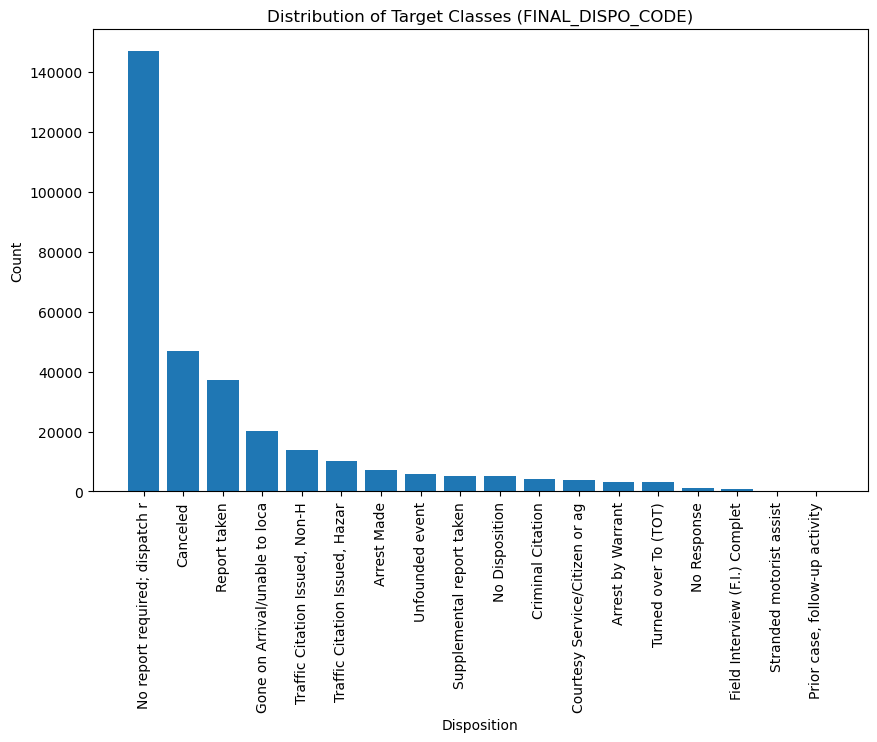

In [34]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [40]:
model_utils.transform_offense_date(all_police_df)

In [42]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    307959
A          7225
C          4214
B          3226
Name: count, dtype: int64

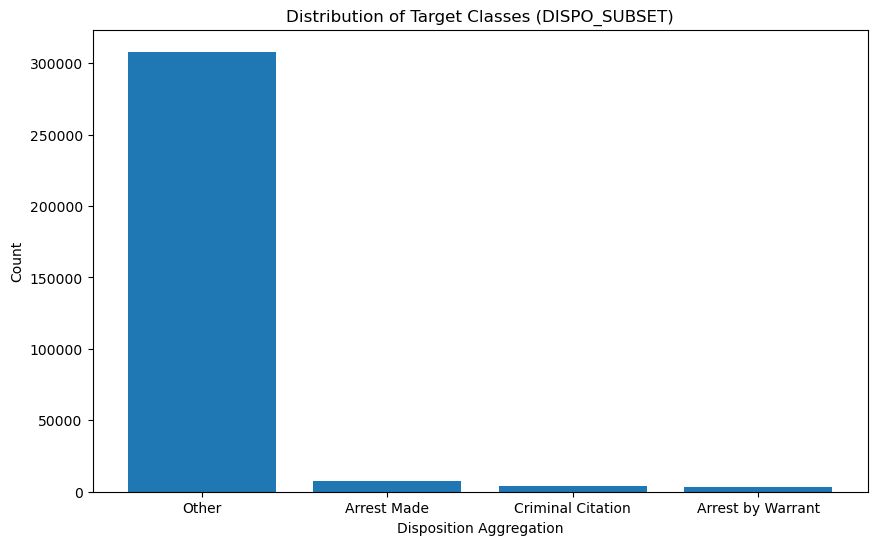

In [44]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [47]:
encoder = joblib.load('one_hot_encoder.pkl')

In [49]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 322624 rows before cleaning, 287658 rows after cleaning.


(287658, 535)

## Define X and Y

In [51]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(230126, 534)
(57532, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 219616, 0: 5234, 2: 2982, 1: 2294})
Counter({3: 10510, 0: 5234, 2: 2982, 1: 2294})


y_train distribution: Counter({3: 219616, 0: 5234, 2: 2982, 1: 2294})
y_test distribution: Counter({3: 54904, 0: 1309, 2: 746, 1: 573})
y_train_resampled distribution: Counter({3: 219616, 0: 5234, 2: 2982, 1: 2294})


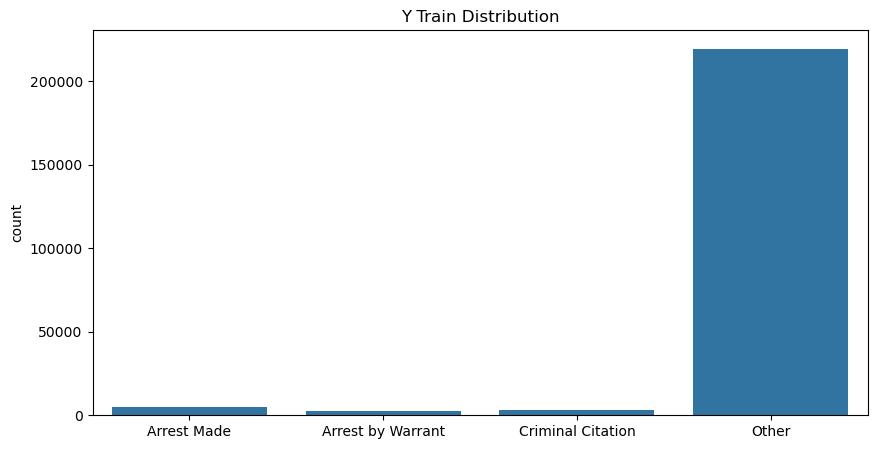

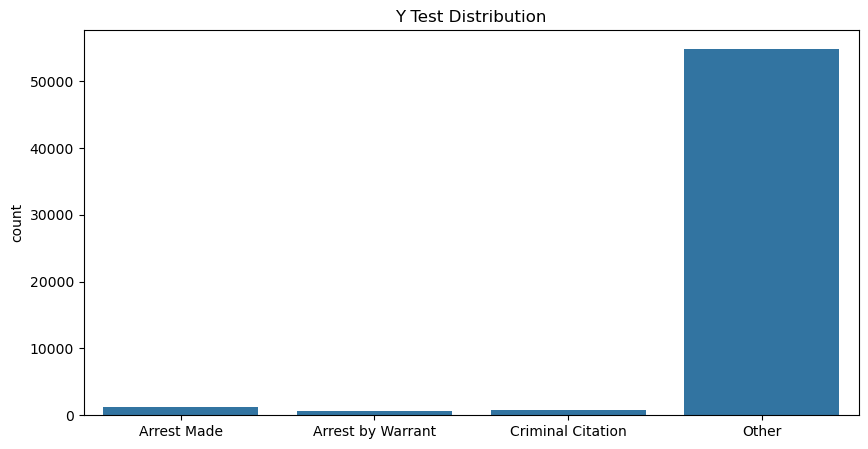

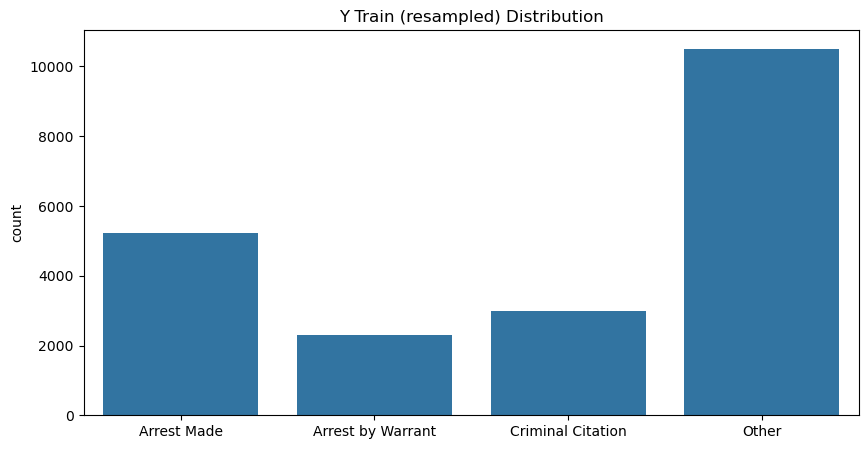

In [52]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [56]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [57]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [58]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1309
Arrest by Warrant       0.00      0.00      0.00       573
Criminal Citation       0.00      0.00      0.00       746
            Other       0.95      1.00      0.98     54904

         accuracy                           0.95     57532
        macro avg       0.24      0.25      0.24     57532
     weighted avg       0.91      0.95      0.93     57532



### Logistic Regression

In [60]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [61]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [62]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.18      0.59      0.28      1309
Arrest by Warrant       0.46      0.62      0.53       573
Criminal Citation       0.16      0.58      0.26       746
            Other       0.99      0.90      0.94     54904

         accuracy                           0.88     57532
        macro avg       0.45      0.67      0.50     57532
     weighted avg       0.95      0.88      0.91     57532



#### Hyperparameter Tuning

In [65]:
grid_search_scoring_method = 'f1_macro'

In [70]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [71]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 0.1}
Best Score (f1_macro): 0.5954


In [72]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2019/best_logistic_regression.pkl']

In [73]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [74]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.60      0.32      0.42      1309
Arrest by Warrant       0.72      0.60      0.65       573
Criminal Citation       0.50      0.28      0.36       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.70      0.55      0.60     57532
     weighted avg       0.96      0.96      0.96     57532



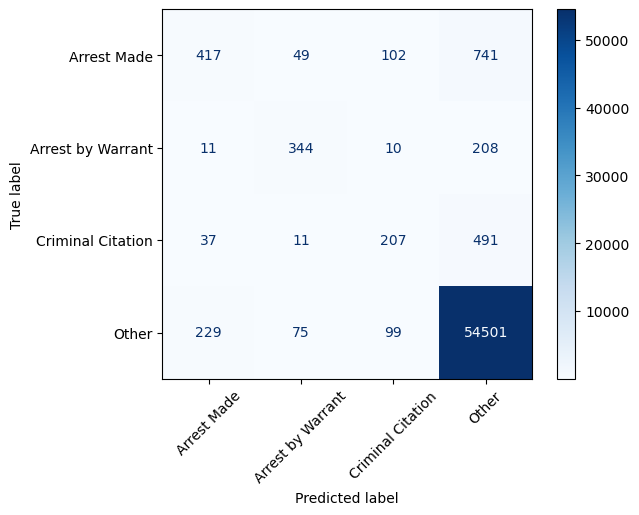

In [75]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [77]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [78]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [79]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                       Feature  Importance  \
205                           CALLTYPE_CODE_6M    0.007851   
189                         CALLTYPE_CODE_601T    0.004722   
64                         CALLTYPE_CODE_11300    0.004172   
204                           CALLTYPE_CODE_6F    0.002839   
69                         CALLTYPE_CODE_11377    0.002405   
112                        CALLTYPE_CODE_23152    0.002115   
85                         CALLTYPE_CODE_12020    0.001188   
89                         CALLTYPE_CODE_14601    0.001188   
0                                     PRIORITY    0.001159   
91                           CALLTYPE_CODE_148    0.000985   
170                          CALLTYPE_CODE_484    0.000927   
119                          CALLTYPE_CODE_242    0.000927   
13                         CALLTYPE_CODE_1033A    0.000869   
66                         CALLTYPE_CODE_11350    0.000811   
49                        CALLTYPE_CODE_10851R    0.000753   
201     

In [80]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
107               Call Type: PARKING VIOLATION    -0.358046
49         Call Type: RECOVERED STOLEN VEHICLE     0.344142
13                   Call Type: ALARM, AUDIBLE    -0.338397
189                   Call Type: TRUANT (TABS)     0.332135
112                 Call Type: MISDEMEANOR DUI     0.223496
231   Call Type: VIOLATION OF PROTECTIVE ORDER     0.211463
153              Call Type: DISTURBANCE, MUSIC    -0.189099
146             Call Type: DISTURBANCE, FAMILY     0.181530
47                   Call Type: STOLEN VEHICLE     0.168896
0                                     PRIORITY    -0.166328
212               Call Type: UNK TYPE 911 CALL    -0.159412
180       Call Type: MENTALLY DISTURBED PERSON     0.157745
201                 Call Type: DRUNK IN PUBLIC     0.154480
125      Call Type: ASSAULT WITH DEADLY WEAPON     0.150294
140            Call Type: EXPIRED REGISTRATION    -0.143508
64                 

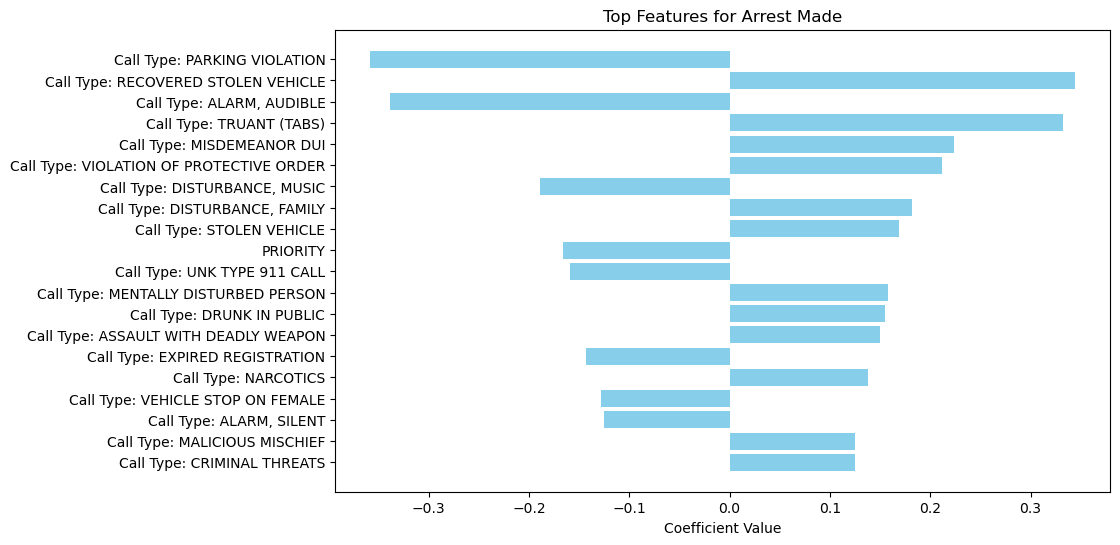

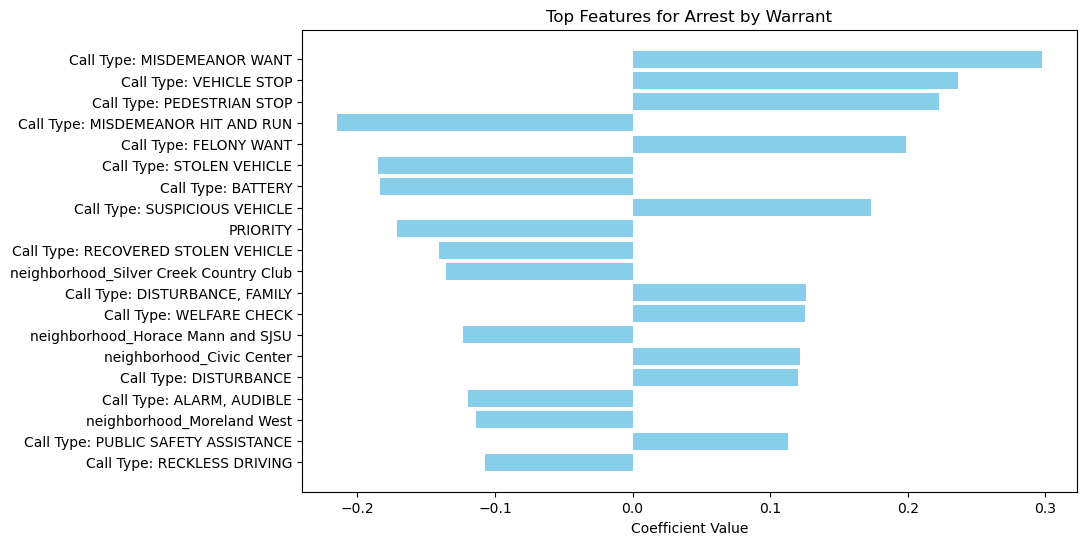

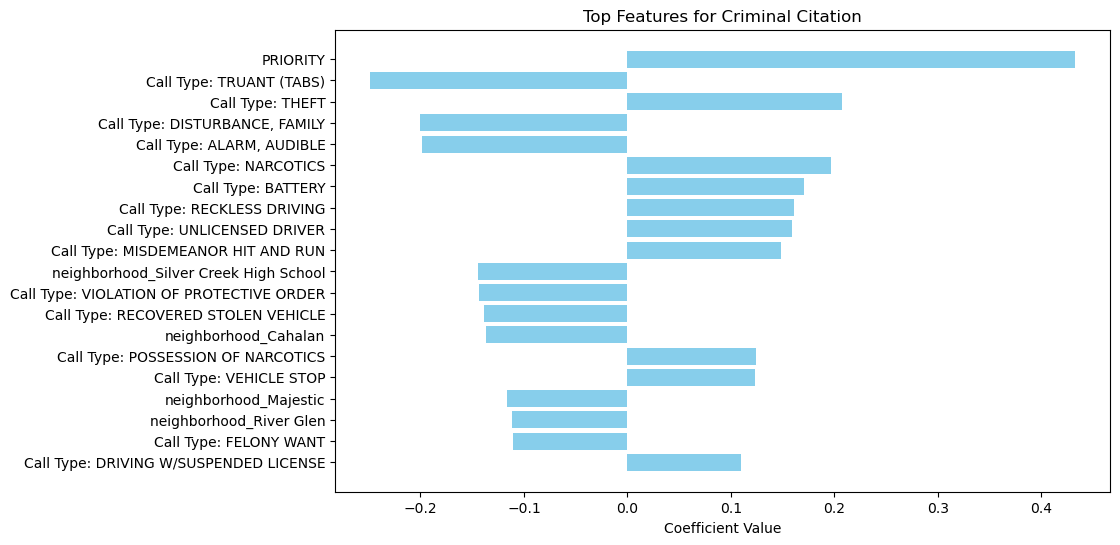

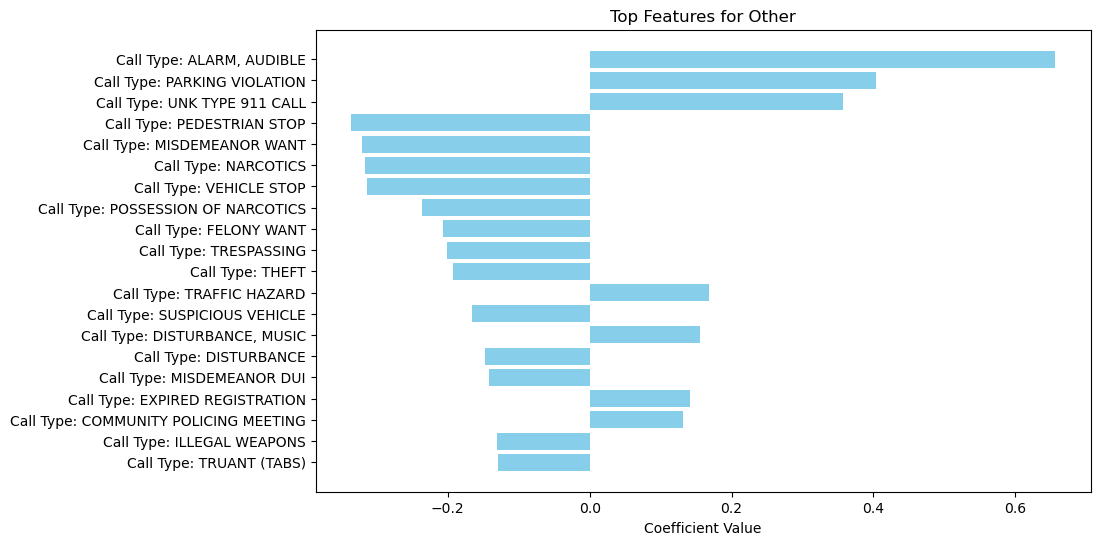

In [81]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [83]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [84]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.33      0.42      1309
Arrest by Warrant       0.62      0.53      0.57       573
Criminal Citation       0.42      0.25      0.32       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.65      0.52      0.57     57532
     weighted avg       0.95      0.96      0.96     57532



#### Hyperparameter Tuning and Cross Validation

In [86]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.57


In [87]:
best_rf = grid_rf.best_estimator_

In [88]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2019/best_random_forest.pkl']

In [92]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [94]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.33      0.42      1309
Arrest by Warrant       0.64      0.54      0.59       573
Criminal Citation       0.42      0.26      0.32       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.65      0.53      0.58     57532
     weighted avg       0.95      0.96      0.96     57532



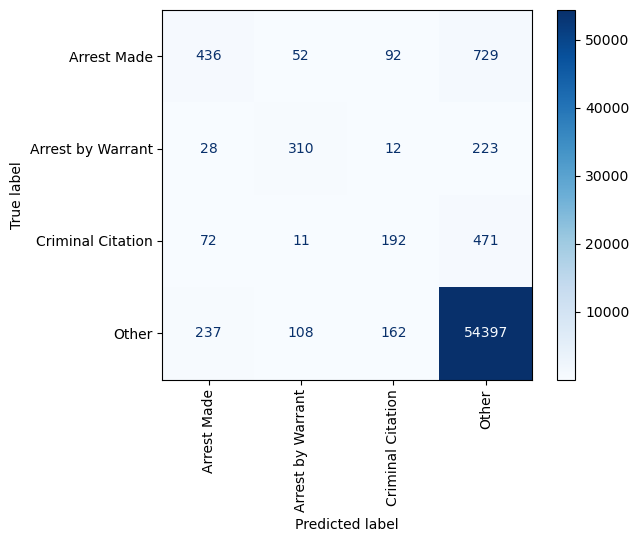

In [95]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

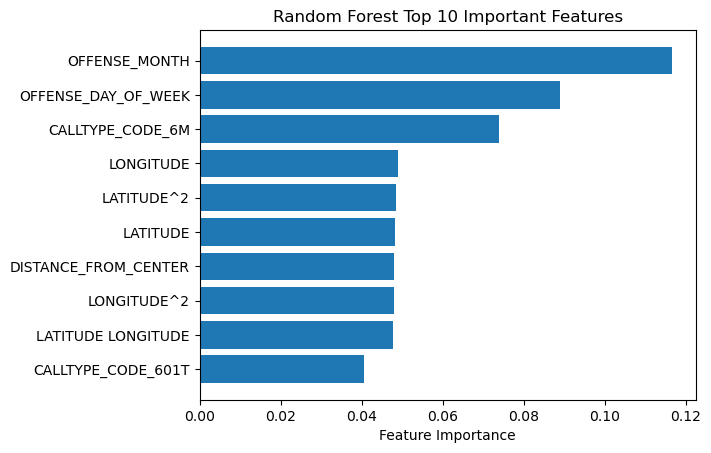

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [99]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [100]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [101]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [102]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9536 - loss: 0.1906 - val_accuracy: 0.9628 - val_loss: 0.1349
Epoch 2/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9620 - loss: 0.1384 - val_accuracy: 0.9637 - val_loss: 0.1340
Epoch 3/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9622 - loss: 0.1351 - val_accuracy: 0.9630 - val_loss: 0.1336
Epoch 4/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9621 - loss: 0.1324 - val_accuracy: 0.9638 - val_loss: 0.1348
Epoch 5/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9627 - loss: 0.1290 - val_accuracy: 0.9628 - val_loss: 0.1356
Epoch 6/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9630 - loss: 0.1285 - val_accuracy: 0.9629 - val_loss: 0.1333
Epoch 7/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9642 - loss: 0.1232 - val_accuracy: 0.9630 - val_loss: 0.1374
Epoch 8/20
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9648 - loss: 0.1209 - 

In [103]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2019/mlp_model.pkl']

In [104]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [105]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 449us/step - accuracy: 0.9626 - loss: 0.1349
Test Accuracy: 0.9625


In [106]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.29      0.39      1309
Arrest by Warrant       0.72      0.58      0.64       573
Criminal Citation       0.43      0.08      0.14       746
            Other       0.97      0.99      0.98     54904

         accuracy                           0.96     57532
        macro avg       0.68      0.49      0.54     57532
     weighted avg       0.95      0.96      0.95     57532



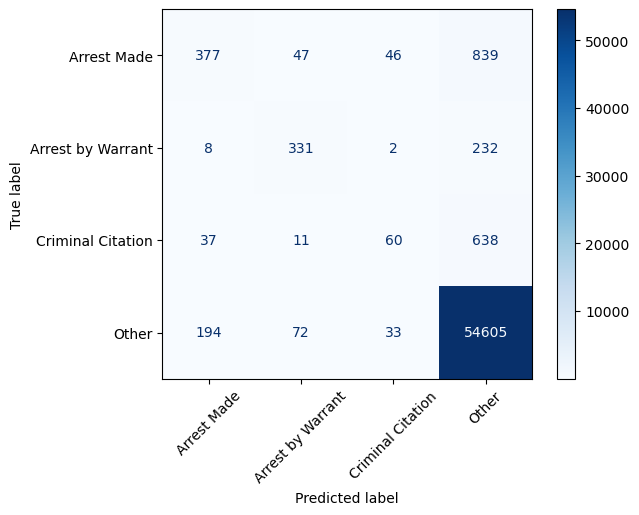

In [107]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [110]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 12:10:32,693] A new study created in memory with name: no-name-803bf5e7-b384-44e6-96b4-4c9f74547667
[I 2024-10-04 12:10:49,641] Trial 0 finished with value: 0.6965051889607942 and parameters: {'n_estimators': 342, 'learning_rate': 0.1673881160308216, 'max_depth': 3, 'subsample': 0.8570598887124845, 'colsample_bytree': 0.6103552247854741, 'gamma': 0.027626870043341384, 'reg_alpha': 0.024581032994824368, 'reg_lambda': 0.004437196160745491}. Best is trial 0 with value: 0.6965051889607942.
[I 2024-10-04 12:11:38,814] Trial 1 finished with value: 0.6609153596733629 and parameters: {'n_estimators': 397, 'learning_rate': 0.22521263281139117, 'max_depth': 12, 'subsample': 0.8602506076531359, 'colsample_bytree': 0.853647108294159, 'gamma': 0.00023013213890772497, 'reg_alpha': 8.96355998277639e-06, 'reg_lambda': 6.810638217761489e-08}. Best is trial 0 with value: 0.6965051889607942.
[I 2024-10-04 12:11:55,558] Trial 2 finished with value: 0.6673821821876589 and parameters: {'n_esti

Actual runtime: 466.99 seconds (7.78 minutes)
Best parameters found:  {'n_estimators': 342, 'learning_rate': 0.1673881160308216, 'max_depth': 3, 'subsample': 0.8570598887124845, 'colsample_bytree': 0.6103552247854741, 'gamma': 0.027626870043341384, 'reg_alpha': 0.024581032994824368, 'reg_lambda': 0.004437196160745491}
Best F1 macro score:  0.6965051889607942


In [111]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6103552247854741, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.027626870043341384, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1673881160308216, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=342, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [112]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.34      0.44      1309
Arrest by Warrant       0.71      0.61      0.66       573
Criminal Citation       0.51      0.30      0.38       746
            Other       0.98      0.99      0.98     54904

         accuracy                           0.97     57532
        macro avg       0.71      0.56      0.62     57532
     weighted avg       0.96      0.97      0.96     57532



In [113]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2019/xgb_model.pkl']

In [114]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [116]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [117]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.6023527785344791
RF F1: 0.5771423731218454
XGB F1: 0.6170228676797236


In [118]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [120]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6103552247854741,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                              learning_rate=0.1673881160308216,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=342, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [121]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2019/stacking_1.pkl']

In [122]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [123]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.6086738517576149


#### Stacking #2

In [125]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6103552247854741,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [126]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2019/stacking_2.pkl']

In [127]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [128]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6193669405041131


## Results

In [130]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.954321,0.250000,0.238580,0.244157
Logistic Regression,0.964142,0.547263,0.697125,0.602353
Random Forest,0.961813,0.530557,0.650562,0.577142
MLP,0.962473,0.485163,0.681300,0.537288
XGB,0.965497,0.561209,0.713871,0.617023
Stack 1,0.965132,0.549292,0.706503,0.608674
Stack 2,0.965445,0.567605,0.700780,0.619367


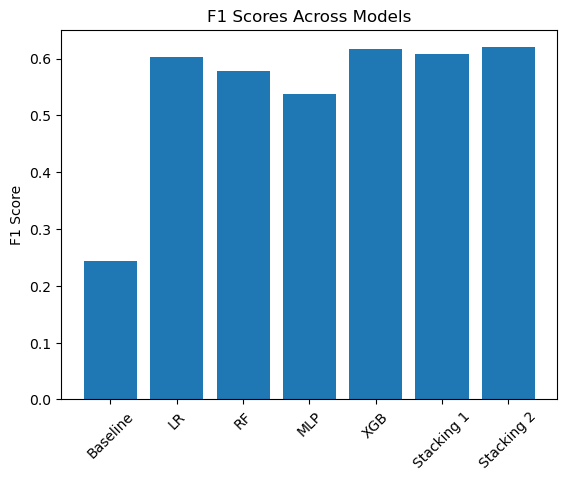

In [131]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [133]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [134]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

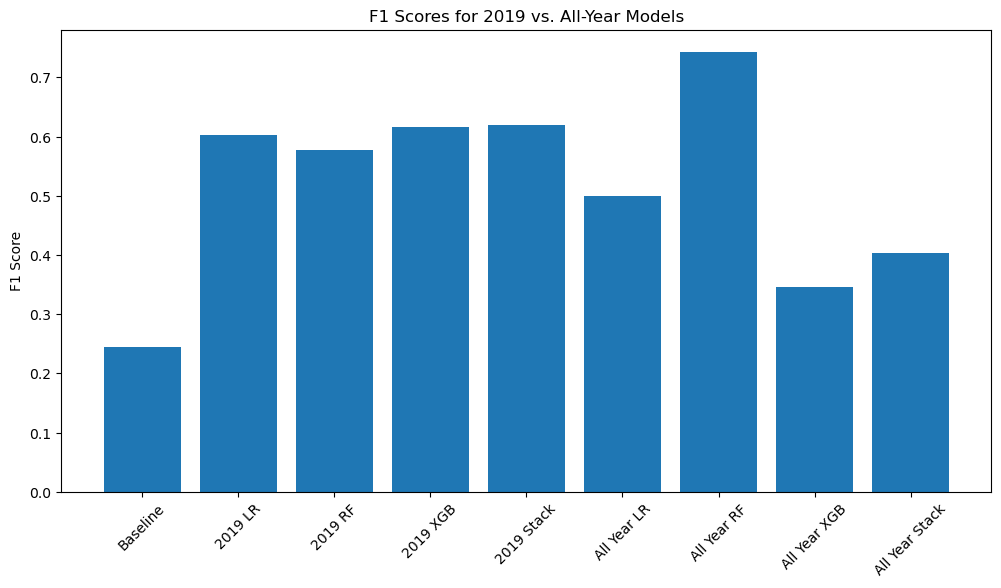

In [187]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()